# Brainglobe pipeline 
## Compare locations of GABAergic neurons from 2 mouse brains in the Common Coordinates Framework

### About this notebook

This notebook uses <a href="https://brainglobe.info/documentation/brainglobe-workflows/index.html">brainglobe workflows</a> to 
* align two serial two-photon tomography (STPT) imaged mouse brains to the common coordinate framework / Allen mouse brain <a href="https://atlas.brain-map.org/">atlas</a> (CCFv3)
* count bright soma in them
* compare locations of the soma in common coordinates using <a href="https://brainglobe.info/documentation/brainrender/index.html">brainrender</a>
<br><br>
The brains (data and metadata) are publicly available at BIL:
* <a href="https://api.brainimagelibrary.org/web/view?bildid=ace-dub-hot">brain 1</a>
* <a href="https://api.brainimagelibrary.org/web/view?bildid=ace-dub-how">brain 2</a>
<br>

To get started with this pipeline, run all cells in this notebook.

### Software requirements

This section will install and import all required packages

In [ ]:
!pip install --no-deps brainglobe-workflows  # avoid installing tensorflow
!pip install --no-deps -U cellfinder  # avoid installing tensorflow
!pip install --upgrade --upgrade-strategy only-if-needed cellfinder-core
!pip install -U brainreg

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage import exposure

In [2]:
# helper function for the plots

def stretch_contrast(img):
    img_dtype = img.dtype
    dtype_max = np.iinfo(img_dtype).max
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    img = (img * dtype_max).astype(img_dtype)
    return img

### First brain

#### Define paths to signal and background channels.
Signal channel will be used to detect cells. Background image will be used for atlas alignment. If background image is not available, use the path to the signal image.

In [3]:
# Dataset:  https://api.brainimagelibrary.org/web/view?bildid=ace-dub-hot

signal_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0078/STPT/stitchedImage_ch1/"
background_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0078/STPT/stitchedImage_ch2/"

#### Define output location.
This will save the outputs in the corresponding subfolder within your home directory

In [4]:
output_location_brain1 = os.path.expanduser("~/workshop/brainmapper_out/brain1")
print("Output will be saved at", output_location_brain1)

Output will be saved at /bil/users/noisysky/workshop/brainmapper_out/brain1


#### Run registration and cell detection.
This step can take awhile as the input images are large. Follow the logs output to check the progress.<br>
Refer to the brainmapper <a href="https://brainglobe.info/documentation/brainglobe-workflows/brainmapper/cli.html">docs</a> to adjust the orientation and voxel spacing for your specific experiment.<br>
We skip cell classification part for the sake of simplicity.

In [ ]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain1} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-classification --no-analyse --no-figures --ball-z-size 50

#### Visualize registration and cell detection

In [6]:
from imlib.IO.cells import get_cells
all_detections = get_cells(os.path.join(output_location_brain1, 'points', "cells.xml"), cells_only=False)
all_detected_spots = []

for cell in all_detections:
    all_detected_spots.append([cell.z, cell.y, cell.x])

all_detected_spots = np.asarray(all_detected_spots)
np.save(os.path.join(output_location_brain1, 'points', "cells.npy"), all_detected_spots)

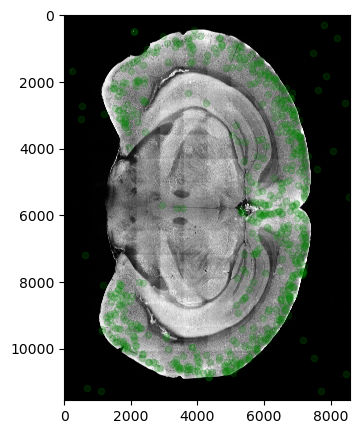

In [7]:
layer_to_show = 116
files = sorted(os.listdir(signal_channel))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(tifffile.imread(os.path.join(signal_channel, files[layer_to_show]))), cmap="gray")
points = all_detected_spots[all_detected_spots[:,0] == layer_to_show]
plt.scatter(x=points[:,2], y=points[:,1], c='g', s=20, alpha=0.2)

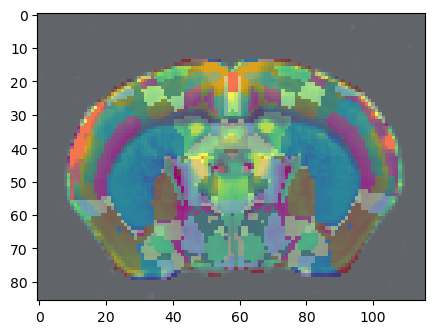

In [8]:
plot_layer = 60
downsampled_img = tifffile.imread(os.path.join(output_location_brain1, "registration/downsampled.tiff"))
boundary_img = tifffile.imread(os.path.join(output_location_brain1, "registration/registered_atlas.tiff"))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(downsampled_img[plot_layer,:,:]))
values, indices = np.unique(boundary_img, return_inverse=True)
indices = indices.reshape(boundary_img.shape)
plt.imshow(indices[plot_layer,:,:], cmap="Accent", alpha=0.5)

In [9]:
# mock cell classification results: all detections are considered genuine cells.
from imlib.cells.cells import Cell
for cell in all_detections:
    cell.type = Cell.CELL

from imlib.IO.cells import save_cells
save_cells(all_detections, os.path.join(output_location_brain1, 'points', "cell_classification.xml"))

#### Transform detected cell coordinates to the atlas space

In [ ]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain1} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-detection --no-register --no-classification --ball-z-size 50

### Second brain

#### Define paths to signal and background channels.

In [11]:
# https://api.brainimagelibrary.org/web/view?bildid=ace-dub-how

signal_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0081/STPT/stitchedImage_ch1/"
background_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0081/STPT/stitchedImage_ch2/"

#### Define output location.

In [12]:
output_location_brain2 = os.path.expanduser("~/workshop/brainmapper_out/brain2")

#### Run registration and cell detection.

In [ ]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain2} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-classification --no-analyse --no-figures --ball-z-size 50

#### Visualize registration and cell detection

In [14]:
from imlib.IO.cells import get_cells
all_detections = get_cells(os.path.join(output_location_brain2, 'points', "cells.xml"), cells_only=False)
all_detected_spots = []

for cell in all_detections:
    all_detected_spots.append([cell.z, cell.y, cell.x])

all_detected_spots = np.asarray(all_detected_spots)
np.save(os.path.join(output_location_brain2, 'points', "cells.npy"), all_detected_spots)

In [15]:
from imlib.cells.cells import Cell
for cell in all_detections:
    cell.type = Cell.CELL
    from imlib.IO.cells import save_cells
save_cells(all_detections, os.path.join(output_location_brain2, 'points', "cell_classification.xml"))

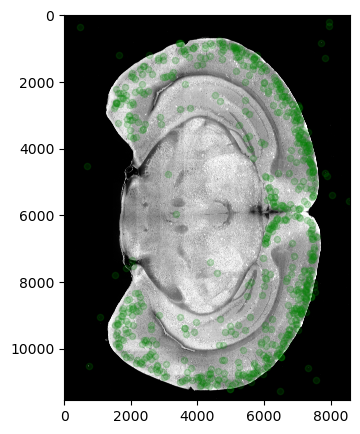

In [16]:
layer_to_show = 116
files = sorted(os.listdir(signal_channel))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(tifffile.imread(os.path.join(signal_channel, files[layer_to_show]))), cmap="gray")
points = all_detected_spots[all_detected_spots[:,0] == layer_to_show]
plt.scatter(x=points[:,2], y=points[:,1], c='g', s=20, alpha=0.2)

In [17]:
downsampled_img = tifffile.imread(os.path.join(output_location_brain2, "registration/downsampled.tiff"))
boundary_img = tifffile.imread(os.path.join(output_location_brain2, "registration/registered_atlas.tiff"))

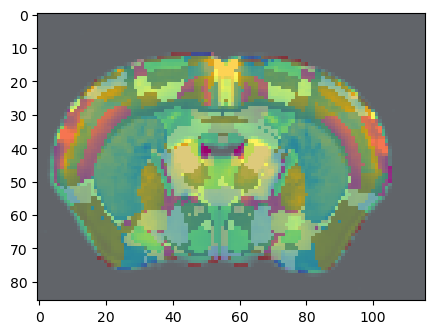

In [18]:
plot_layer = 60
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(downsampled_img[plot_layer,:,:]))
values, indices = np.unique(boundary_img, return_inverse=True)
indices = indices.reshape(boundary_img.shape)
plt.imshow(indices[plot_layer,:,:], cmap="Accent", alpha=0.5)

#### Transform detected cell coordinates to the atlas space

In [ ]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain2} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-detection --no-register --no-classification

### Compare two brains in brainrender

In [20]:
from brainrender.scene import Scene
from brainrender.actors import Points

import vedo
vedo.settings.default_backend= 'k3d'

In [21]:
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
atlas = BrainGlobeAtlas("allen_mouse_100um")

def is_within_brain(point):
    if np.any(point < 0):
        return False
    point = point / atlas.resolution
    try:
        structure = atlas.structure_from_coords(point)
    except IndexError:
        structure = 0
    return structure != 0

cells_path_brain1 = os.path.join(output_location_brain1, 'points', "points.npy")
cells_path_brain2 = os.path.join(output_location_brain2, 'points', "points.npy")

scene = Scene(atlas_name="allen_mouse_100um")
scene.add_brain_region('Isocortex', alpha=0.2)

cells_brain1 = np.load(cells_path_brain1)
filtered_cells_brain1 = list(filter(is_within_brain, list(cells_brain1)))
filtered_cells_brain1 = np.array(filtered_cells_brain1)[::10]

cells_brain2 = np.load(cells_path_brain2)
filtered_cells_brain2 = list(filter(is_within_brain, list(cells_brain2)))
filtered_cells_brain2 = np.array(filtered_cells_brain2)[::10]

cells1 = Points(filtered_cells_brain1, radius=30, colors="blue", alpha=0.8)
cells2 = Points(filtered_cells_brain2, radius=30, colors="orange", alpha=0.8)

scene.add(cells1)
scene.add(cells2)

scene.render()

cells_brain1 (107884, 3)
filtered_cells_brain1 94018


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

In [22]:
from vedo import Plotter  # <- this will be used to render an embedded scene 
plt = Plotter()
plt.show(*scene.renderables)

/bil/users/noisysky/.local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

This prosuces an interactive 3D visualization like shown in a screenshot below. <br>
If the visualization doesn't show, restart the kernel, and re-run the notebook.

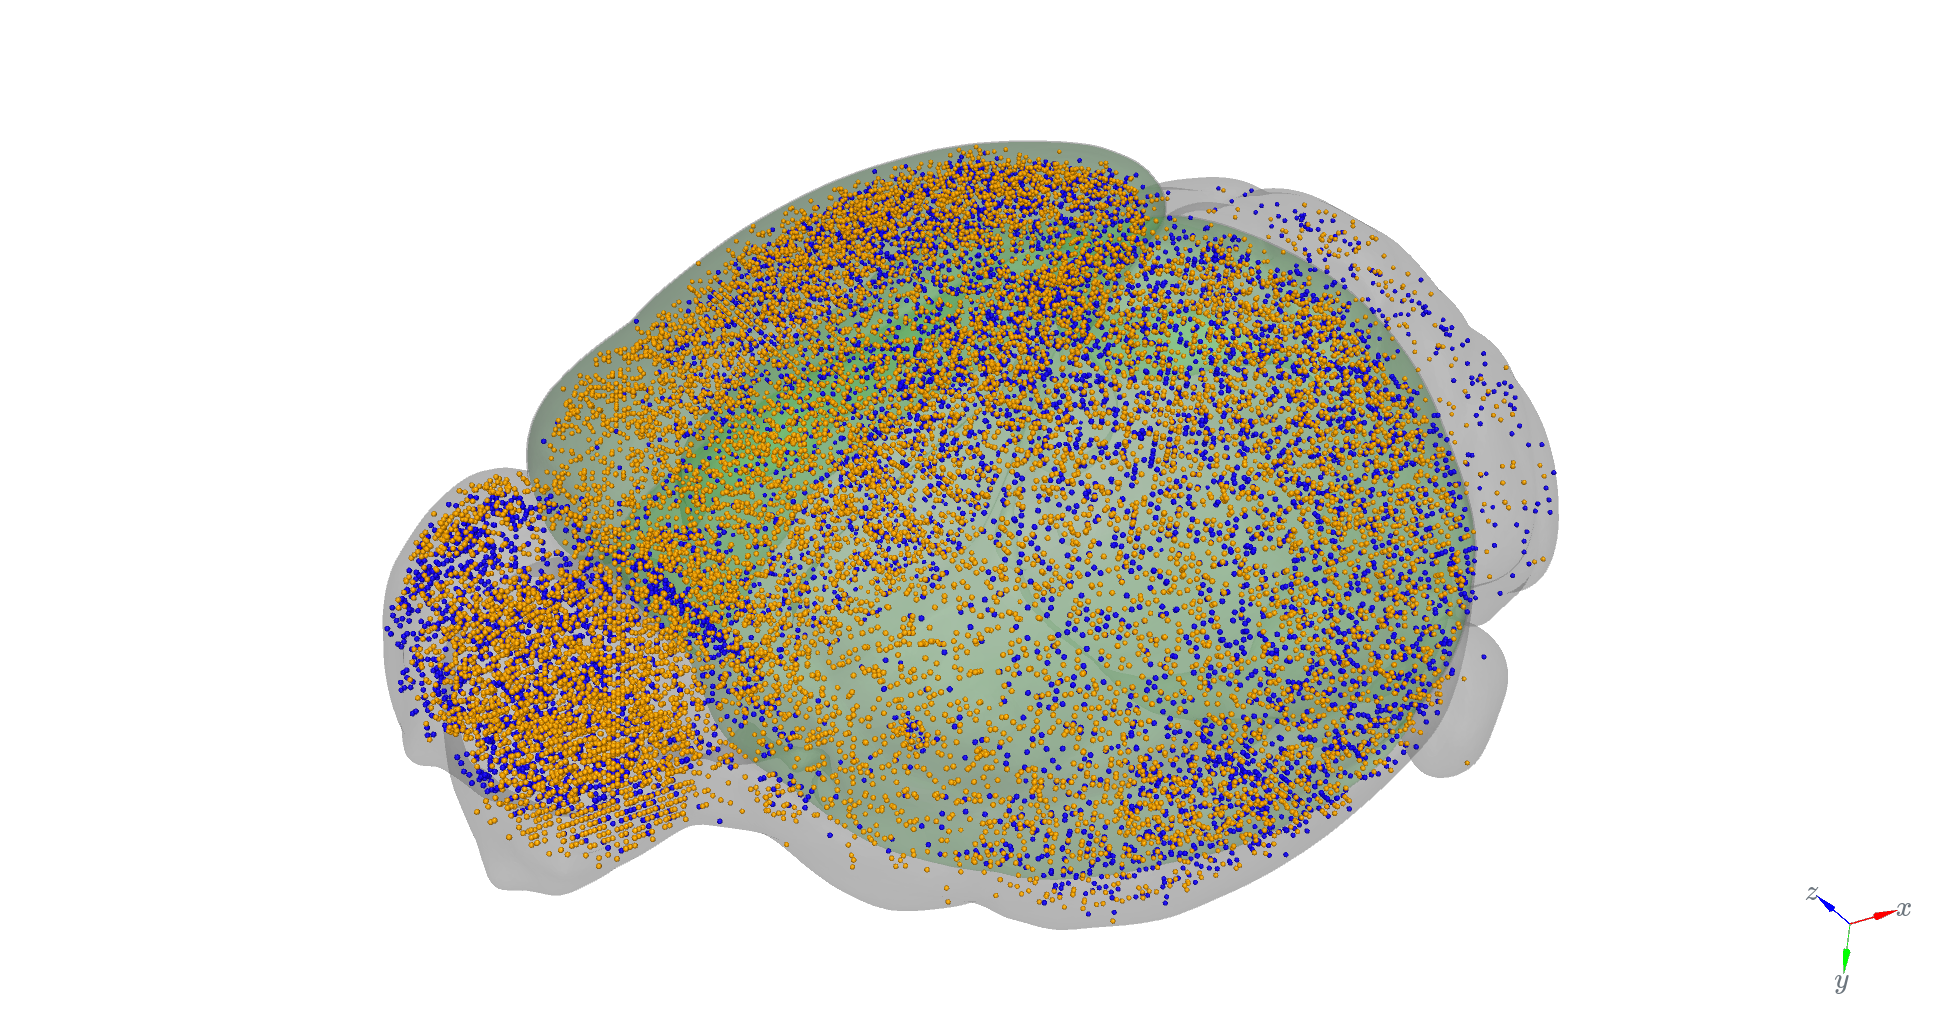

In [24]:
from IPython.display import Image
Image("./K3D-1714146909240.png")